# GPT-5 Vision + HF Grounding DINO + SAM — Glow Highlights (No Compilation)
Pipeline:
1) **GPT-5 Vision** returns teaching sentences + coarse boxes (your JSON schema)
2) **Grounding DINO (Transformers)** refines a box per sentence (no C++/CUDA build)
3) **SAM** converts the box to a tight mask
4) Optional line/text refinement, then **glow rendering** over the original image

## 1) Setup

In [ ]:

!pip -q install --upgrade pip wheel setuptools
!pip -q install "transformers>=4.44.2" timm accelerate torchvision torch --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install pillow opencv-python-headless numpy matplotlib
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
!pip -q install supervision==0.6.0 pytesseract easyocr
!pip -q install --upgrade openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 2) Imports & device

In [ ]:

import os, io, base64, json, re
from pathlib import Path
import numpy as np
from PIL import Image, ImageFilter, ImageDraw, ImageChops
import cv2
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


## 3) OpenAI client (matches your function signature)

In [ ]:

from openai import OpenAI
from google.colab import userdata
class settings:
    OPENAI_API_KEY = userdata.get('openai')

client = OpenAI(api_key=settings.OPENAI_API_KEY)
assert settings.OPENAI_API_KEY, "Please set OPENAI_API_KEY env var before running GPT-5."
print("OpenAI client ready.")


OpenAI client ready.


## 4) Helpers

In [ ]:

def load_image_from_path_or_b64(image_input):
    if isinstance(image_input, str) and Path(image_input).exists():
        return Image.open(image_input).convert("RGB")
    if isinstance(image_input, (bytes, bytearray)):
        return Image.open(io.BytesIO(image_input)).convert("RGB")
    if isinstance(image_input, str):
        if image_input.startswith("data:image"):
            _, b64 = image_input.split(",", 1)
        else:
            b64 = image_input
        pad = len(b64) % 4
        if pad:
            b64 += "=" * (4 - pad)
        return Image.open(io.BytesIO(base64.b64decode(b64))).convert("RGB")
    raise ValueError("Unsupported image input")

def pil_to_base64_png(im: Image.Image) -> str:
    buf = io.BytesIO()
    im.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def normalize_xywh_to_xyxy(x, y, w, h, W, H):
    cx, cy = x*W, y*H
    ww, hh = w*W, h*H
    x1, y1 = int(max(0, cx - ww/2)), int(max(0, cy - hh/2))
    x2, y2 = int(min(W-1, cx + ww/2)), int(min(H-1, cy + hh/2))
    return [x1, y1, x2, y2]

def expand_box(xyxy, W, H, pad_ratio=0.06):
    x1, y1, x2, y2 = xyxy
    bw, bh = x2-x1, y2-y1
    pad_w, pad_h = int(bw*pad_ratio), int(bh*pad_ratio)
    return [max(0, x1-pad_w), max(0, y1-pad_h),
            min(W-1, x2+pad_w), min(H-1, y2+pad_h)]

def rect_mask(size_wh, xyxy, feather=0):
    W, H = size_wh
    x1, y1, x2, y2 = map(int, xyxy)
    m = Image.new("L", (W, H), 0)
    d = ImageDraw.Draw(m)
    d.rectangle([x1, y1, x2, y2], fill=255)
    if feather > 0:
        m = m.filter(ImageFilter.GaussianBlur(radius=feather))
    return m

def glow_composite(base_rgb: Image.Image, mask_L: Image.Image, blur=24, intensity=0.9, color=(255,255,0)):
    blurred = mask_L.filter(ImageFilter.GaussianBlur(blur))
    rgba = Image.new("RGBA", base_rgb.size, (0,0,0,0))
    a = np.array(blurred, dtype=np.float32) * float(intensity)
    a = np.clip(a, 0, 255).astype(np.uint8)
    arr = np.zeros((base_rgb.height, base_rgb.width, 4), dtype=np.uint8)
    arr[...,0], arr[...,1], arr[...,2], arr[...,3] = color[0], color[1], color[2], a
    overlay = Image.fromarray(arr, "RGBA")
    out = Image.alpha_composite(base_rgb.convert("RGBA"), overlay)
    return out.convert("RGB")


## 5) GPT-5 Vision function (exact signature)

In [ ]:

def _parse_gpt5_sentences_json(content: str):
    import json, re
    # try direct parse
    try:
        return json.loads(content)
    except json.JSONDecodeError:
        pass
    # try fenced block
    m = re.search(r"```(?:json)?\\s*(\\{.*?\\})\\s*```", content, re.DOTALL)
    if m:
        try:
            return json.loads(m.group(1))
        except json.JSONDecodeError:
            pass
    # try to salvage the sentences array by trimming the last incomplete object
    m = re.search(r'"sentences"\\s*:\\s*\\[(.*)', content, re.DOTALL)
    if not m:
        raise ValueError("Could not find 'sentences' in GPT-5 output.")
    body = m.group(1)
    # keep everything up to the last complete closing brace followed by comma or end
    # then close the JSON
    trimmed = body.rsplit("}", 1)[0] + "}"
    # ensure comma separation is valid
    trimmed = re.sub(r"}\\s*{", "},{", trimmed)
    salvage = "{\\n  \"sentences\": [" + trimmed + "]\\n}"
    try:
        return json.loads(salvage)
    except Exception as e:
        raise ValueError(f"Failed to salvage GPT-5 JSON: {e}\\nFirst 500 chars:\\n{content[:500]}")

def generate_explanation_with_gpt5(image_base64):
    """
    Use GPT-5 Vision to analyze a slide and produce 5–8 explanatory sentences
    with bounding boxes.  Returns a list of dicts like:
    [{"text": "...", "x": 0.5, "y": 0.4, "width": 0.3, "height": 0.2}, ...]
    """
    prompt_text = """You are an expert educator analyzing a lecture slide. Your goal is to EXPLAIN the concepts illustrated, not just describe what you see visually.

Write 5-8 sentences that teach the key concepts shown on this slide. Each sentence should:
- Explain a concept, principle, or relationship illustrated in the slide
- Be pedagogical—teach as if to a student learning this material
- Reference WHERE the concept is shown (so students know what to look at)

For each explanatory sentence, provide bounding box coordinates:
- x: horizontal center (0.0 = left edge, 1.0 = right edge)
- y: vertical center (0.0 = top edge, 1.0 = bottom edge)
- width: box width (0.0–1.0)
- height: box height (0.0–1.0)

Return JSON only:
{
  "sentences": [
    { "text": "Concept explanation", "x": 0.3, "y": 0.2, "width": 0.3, "height": 0.15 }
  ]
}"""

    def _parse_json(content: str):
        import json, re
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            # Try fenced block
            m = re.search(r"```(?:json)?\\s*(\\{.*?\\})\\s*```", content, re.DOTALL)
            if m:
                return json.loads(m.group(1))
            # Try salvage: cut off unfinished object
            m = re.search(r'"sentences"\\s*:\\s*\\[(.*)', content, re.DOTALL)
            if not m:
                raise
            body = m.group(1).rsplit("}", 1)[0] + "}"
            body = re.sub(r"}\\s*{", "},{", body)
            text = '{ "sentences": [' + body + "]}"
            return json.loads(text)

    try:
        print("Starting GPT-5 analysis...")
        response = client.responses.create(
            model="gpt-5",
            input=[{
                "role": "user",
                "content": [
                    {"type": "input_image", "image_url": f"data:image/png;base64,{image_base64}", "detail": "high"},
                    {"type": "input_text", "text": prompt_text}
                ]
            }],
            text={"verbosity": "medium"},
            reasoning={"effort": "low"},
            max_output_tokens=5000
        )

        # Extract plain text from the multimodal response
        content = None
        if hasattr(response, "output") and response.output:
            for item in response.output:
                if getattr(item, "type", "") != "reasoning":
                    if hasattr(item, "text") and item.text:
                        content = item.text
                        break
                    if hasattr(item, "content") and isinstance(item.content, list) and item.content:
                        first = item.content[0]
                        if hasattr(first, "text"):
                            content = first.text
                            break
        if not content and hasattr(response, "output_text"):
            content = response.output_text
        if not content or not content.strip():
            raise ValueError("GPT-5 returned empty response.")

        data = _parse_json(content)
        sents = []
        for it in data.get("sentences", []):
            if "text" not in it:
                continue
            def clamp(v, default):
                try:
                    return max(0.0, min(1.0, float(v)))
                except Exception:
                    return default
            sents.append({
                "text": str(it["text"]).strip(),
                "x": clamp(it.get("x", 0.5), 0.5),
                "y": clamp(it.get("y", 0.5), 0.5),
                "width": clamp(it.get("width", 0.3), 0.3),
                "height": clamp(it.get("height", 0.15), 0.15),
            })
        return sents

    except Exception as e:
        raise Exception(f"GPT-5 Vision analysis failed: {e}")



## 6) Grounding DINO (Transformers — no compile)

In [ ]:

from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import torch

GDN_ID = "IDEA-Research/grounding-dino-tiny"  # you can switch to base/swin-b later
processor = AutoProcessor.from_pretrained(GDN_ID)
gdn = AutoModelForZeroShotObjectDetection.from_pretrained(GDN_ID).to(DEVICE)

def _gdn_postprocess(outputs, inputs, image_pil, box_threshold=0.35, text_threshold=0.25):
    """Handle different transformers versions gracefully."""
    target_sizes = [image_pil.size[::-1]]
    # Newer signature (with input_ids + thresholds)
    try:
        return processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            target_sizes=target_sizes,
        )[0]
    except TypeError:
        pass
    # Some builds use `threshold=` only
    try:
        return processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            threshold=text_threshold,
            target_sizes=target_sizes,
        )[0]
    except TypeError:
        pass
    # Fallback older helper name
    try:
        return processor.post_process_object_detection(
            outputs,
            threshold=text_threshold,
            target_sizes=target_sizes,
        )[0]
    except TypeError as e:
        raise RuntimeError(f"GDN postprocess signature not supported by this transformers version: {e}")

def refine_with_gdn(image_pil: Image.Image, text_query: str, box_threshold=0.35, text_threshold=0.25):
    inputs = processor(images=image_pil, text=text_query, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = gdn(**inputs)
    return _gdn_postprocess(outputs, inputs, image_pil, box_threshold, text_threshold)

def refine_boxes_with_gdn(sentences, image_pil: Image.Image):
    W, H = image_pil.size
    out = []
    for s in sentences:
        try:
            res = refine_with_gdn(image_pil, s["text"])
            boxes, scores = res.get("boxes", []), res.get("scores", [])
        except Exception:
            boxes, scores = [], []
        if boxes is None or len(boxes) == 0:
            # fallback to GPT-5 coarse box (normalized -> px)
            x1, y1, x2, y2 = normalize_xywh_to_xyxy(s["x"], s["y"], s["width"], s["height"], W, H)
            out.append((s, [x1, y1, x2, y2], 0.0))
        else:
            j = int(torch.tensor(scores).argmax().item())
            out.append((s, boxes[j].cpu().numpy().tolist(), float(scores[j])))
    return out



## 7) SAM mask extraction

In [ ]:

from segment_anything import sam_model_registry, SamPredictor
import numpy as np

SAM_CKPT = "sam_vit_h_4b8939.pth"
if not Path(SAM_CKPT).exists():
    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O {SAM_CKPT}

sam = sam_model_registry["vit_h"](checkpoint=SAM_CKPT).to(DEVICE)
sam_pred = SamPredictor(sam)

def box_to_best_mask(image_pil, xyxy):
    img = np.array(image_pil)
    sam_pred.set_image(img)
    box = np.array(xyxy, dtype=np.float32)
    masks, scores, _ = sam_pred.predict(box=box[None, :], multimask_output=True)
    k = int(np.argmax(scores))
    return masks[k].astype(bool)


## 8) Optional: line/text refinement

In [ ]:

def refine_line_in_mask(image_pil, mask_bool):
    img = np.array(image_pil)
    roi = cv2.bitwise_and(img, img, mask=(mask_bool.astype(np.uint8)*255))

    pts = roi[mask_bool].reshape(-1,3).astype(np.float32)
    if len(pts) < 50:
        return mask_bool

    K = 2
    criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _,labels,centers = cv2.kmeans(pts, K, None, criteria, 2, cv2.KMEANS_PP_CENTERS)
    counts = np.bincount(labels.flatten())
    target = counts.argmin() if len(counts)>1 else 0

    refined = np.zeros(mask_bool.shape, dtype=np.uint8)
    refined[mask_bool] = (labels.flatten()==target).astype(np.uint8)*255
    refined = cv2.morphologyEx(refined, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    return refined>0

try:
    import easyocr
    OCR_AVAILABLE = True
except Exception:
    OCR_AVAILABLE = False

def ocr_text_mask(image_pil, region_xyxy, min_text_score=0.5):
    if not OCR_AVAILABLE:
        return None
    x1, y1, x2, y2 = map(int, region_xyxy)
    crop = image_pil.crop((x1, y1, x2, y2))
    reader = easyocr.Reader(["en"], gpu=torch.cuda.is_available())
    results = reader.readtext(np.array(crop))
    mask = Image.new("L", image_pil.size, 0)
    draw = ImageDraw.Draw(mask)
    for bbox, text, conf in results:
        if conf < min_text_score:
            continue
        poly = [(x1 + int(pt[0]), y1 + int(pt[1])) for pt in bbox]
        draw.polygon(poly, fill=255)
    return mask


## 9) Render pipeline

In [ ]:

def render_glows(image_pil: Image.Image, refined_items, feather=10, blur=28, intensity=0.9,
                 color_cycle=None, prefer_line=True):
    if color_cycle is None:
        color_cycle = [(255,255,0),(0,255,255),(255,0,255),(0,255,128),
                       (255,128,0),(128,0,255),(0,128,255)]
    W,H = image_pil.size
    out = image_pil.copy()
    frames = []

    for idx, (s, xyxy, score) in enumerate(refined_items):
        # Get the tight mask from SAM
        sam_mask_bool = box_to_best_mask(image_pil, xyxy)

        # Check if SAM failed. If so, fall back to a rectangle.
        if sam_mask_bool.sum() < 30:
            mask_L = rect_mask((W,H), xyxy, feather=feather)
        else:
            # SAM mask is good. Now, *optionally* try to refine it to a line.
            if prefer_line:
                line_mask_bool = refine_line_in_mask(image_pil, sam_mask_bool)
                # If line refinement works (finds something), use it.
                # Otherwise, just use the original SAM mask.
                if line_mask_bool.sum() > 30:
                    mask_bool_to_render = line_mask_bool
                else:
                    mask_bool_to_render = sam_mask_bool
            else:
                # We don't prefer a line, so just use the SAM mask.
                mask_bool_to_render = sam_mask_bool

            # Convert the final boolean mask to an 'L' image
            mask_L = Image.fromarray((mask_bool_to_render.astype(np.uint8)*255), mode="L")
            # Apply a slight blur to make the glow source softer
            mask_L = mask_L.filter(ImageFilter.GaussianBlur(radius=2))

        color = color_cycle[idx % len(color_cycle)]
        out = glow_composite(out, mask_L, blur=blur, intensity=intensity, color=color)

        dbg = out.copy()
        draw = ImageDraw.Draw(dbg)
        x1,y1,x2,y2 = map(int, xyxy)
        draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
        frames.append(dbg)

    return out, frames


In [ ]:
from pathlib import Path

def render_each_sentence_image(image_pil: Image.Image, refined_items, save_dir="out/sentences", feather=10, blur=28, intensity=0.9):
    """
    Create a separate glow-highlighted image for each explanatory sentence.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    color_cycle = [(255,255,0),(0,255,255),(255,0,255),(0,255,128),
                   (255,128,0),(128,0,255),(0,128,255)]

    results = []
    for idx, (s, xyxy, score) in enumerate(refined_items):
        # Use SAM to get the mask, just like in the main render function
        mask_bool = box_to_best_mask(image_pil, xyxy)

        if mask_bool.sum() < 30: # Fallback to rect if SAM fails
             mask_L = rect_mask(image_pil.size, xyxy, feather=feather)
        else:
            mask_L = Image.fromarray((mask_bool.astype(np.uint8)*255), mode="L")
            mask_L = mask_L.filter(ImageFilter.GaussianBlur(radius=2)) # Soften the mask

        color = color_cycle[idx % len(color_cycle)]
        highlighted = glow_composite(image_pil, mask_L, blur=blur, intensity=intensity, color=color)

        filename = Path(save_dir) / f"sentence_{idx+1:02d}.png"
        highlighted.save(filename)
        results.append((s["text"], str(filename)))

    return results

## 10) Demo — set your image path or base64

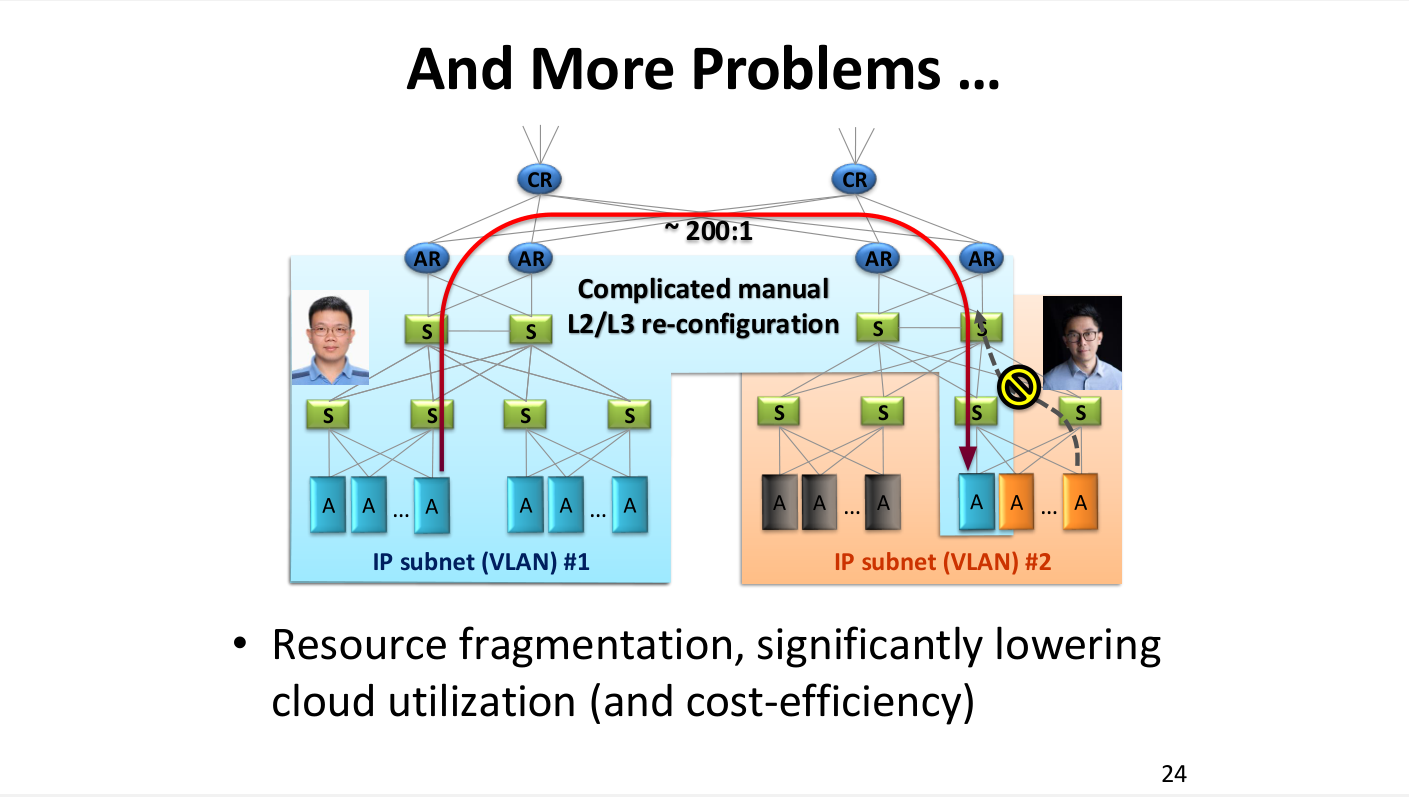

Starting GPT-5 analysis...
{
  "sentences": [
    {
      "text": "The title at the top signals that traditional network designs introduce additional challenges beyond basic connectivity, setting the stage for the problems illustrated below.",
      "x": 0.5,
      "y": 0.11,
      "width": 0.72,
      "height": 0.14
    },
    {
      "text": "The two colored regions labeled IP subnet (VLAN) #1 and #2 show that tying workloads to VLAN-based subnets partitions resources, which can strand capacity on one side while others are overloaded.",
      "x": 0.51,
      "y": 0.6,
      "width": 0.74,
      "height": 0.36
    },
    {
      "text": "The thick red arc across the top with the label ~200:1 illustrates oversubscription: far more east\u2013west traffic demands than the limited cross-rack/core resources can handle.",
      "x": 0.5,
      "y": 0.25,
      "width": 0.74,
      "height": 0.24
    },
    {
      "text": "The text in the center saying Complicated manual L2/L3 re-configura

/tmp/ipython-input-3989571949.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  j = int(torch.tensor(scores).argmax().item())


Refined 7 regions.


/tmp/ipython-input-3792750681.py:32: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_L = Image.fromarray((mask_bool_to_render.astype(np.uint8)*255), mode="L")
/tmp/ipython-input-4146690903.py:53: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  overlay = Image.fromarray(arr, "RGBA")


Saved: out/slide_glow.png and 7 step frames


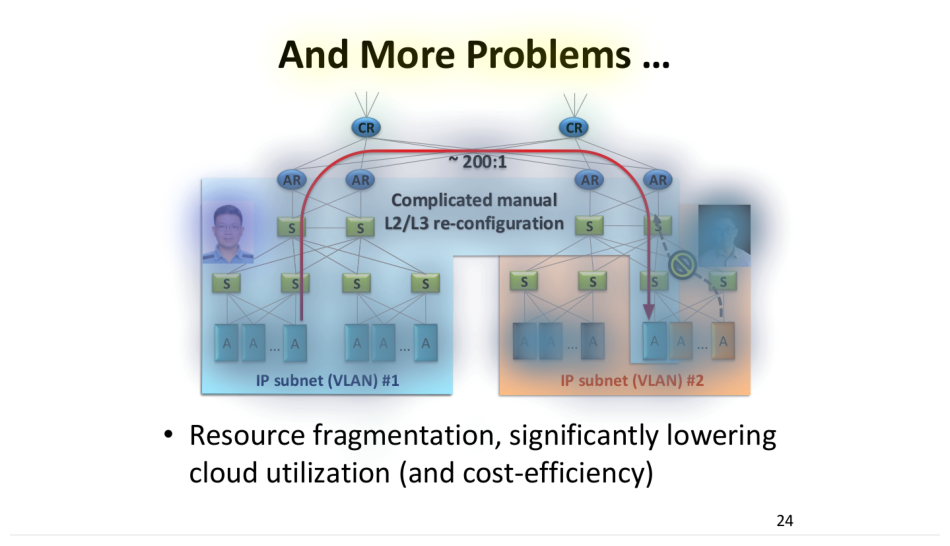

/tmp/ipython-input-2021799224.py:19: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_L = Image.fromarray((mask_bool.astype(np.uint8)*255), mode="L")



Generated individual images:

out/sentences/sentence_01.png:
The title at the top signals that traditional network designs introduce additional challenges beyond basic connectivity, setting the stage for the problems illustrated below.

out/sentences/sentence_02.png:
The two colored regions labeled IP subnet (VLAN) #1 and #2 show that tying workloads to VLAN-based subnets partitions resources, which can strand capacity on one side while others are overloaded.

out/sentences/sentence_03.png:
The thick red arc across the top with the label ~200:1 illustrates oversubscription: far more east–west traffic demands than the limited cross-rack/core resources can handle.

out/sentences/sentence_04.png:
The text in the center saying Complicated manual L2/L3 re-configuration highlights that moving a VM or service across these subnets often requires manual VLAN and routing changes.

out/sentences/sentence_05.png:
On the right, the downward arrow and the prohibition icon indicate that even if capa

In [ ]:

IMAGE_PATH_OR_B64 = "/content/slide.png"  # change to a real path or paste base64 string

from IPython.display import display
import matplotlib.pyplot as plt

im = load_image_from_path_or_b64(IMAGE_PATH_OR_B64)
display(im)

b64_png = pil_to_base64_png(im)

sentences = generate_explanation_with_gpt5(b64_png)
print(json.dumps({"sentences": sentences}, indent=2))

refined = refine_boxes_with_gdn(sentences, im)
print(f"Refined {len(refined)} regions.")

final_img, frames = render_glows(
    im, refined,
    feather=10,
    blur=28,
    intensity=0.9,
    prefer_line=True,
)

Path("out").mkdir(exist_ok=True, parents=True)
final_img.save("out/slide_glow.png")
for i, f in enumerate(frames, 1):
    f.save(f"out/slide_glow_step_{i:02d}.png")

print("Saved:", "out/slide_glow.png", "and", f"{len(frames)} step frames")

plt.figure(figsize=(12,7))
plt.imshow(final_img)
plt.axis("off")
plt.show()

sentence_outputs = render_each_sentence_image(im, refined, save_dir="out/sentences")

print("\nGenerated individual images:")
for text, path in sentence_outputs:
    print(f"\n{path}:\n{text}")
